In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
sys.path.append("../")

import torch
from torch import nn
import torch.nn.functional as F

from cont_speech_experiment import ContinuousSpeechExperiment, ClasswiseDataset
from nupic.research.support import parse_config

from nupic.research.frameworks.continuous_learning.utils import add_sparse_cnn_layer, add_sparse_linear_layer

from nupic.research.frameworks.pytorch.modules import KWinners2dLocal
from nupic.research.frameworks.pytorch.modules.consolidated_sparse_weights import (
    ConsolidatedSparseWeights,
    ConsolidatedSparseWeights2D,
)
from nupic.torch.modules import (
    Flatten,
    KWinners,
    KWinners2d,
    SparseWeights,
    SparseWeights2d,
)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from fb_sparsenet import FBNet

In [71]:
net = FBNet(fb_weight_sparsity=(0.05,))

In [72]:
def one_hot(x):
    return torch.eye(11)[x]

pred = net.linear_fb(one_hot(2).cuda())

In [83]:
w = list(net.linear_fb.named_parameters())[0]

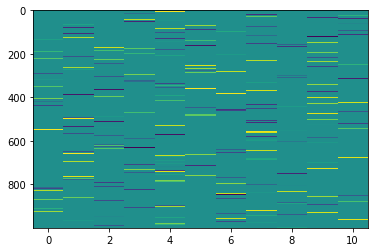

In [84]:
plt.imshow(w[1].cpu().detach().numpy(), aspect="auto")

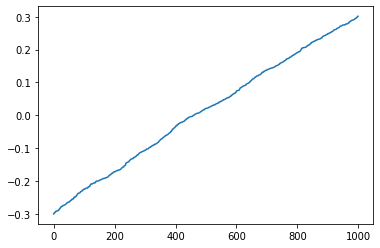

In [85]:
plt.plot(np.sort(np.sum(w[1].cpu().detach().numpy(), axis=1)))

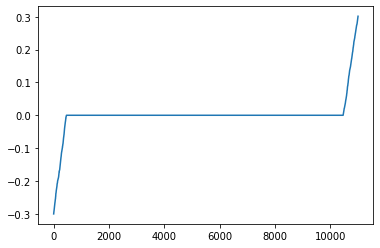

In [86]:
plt.plot(np.sort(w[1].detach().cpu().numpy().flatten()))

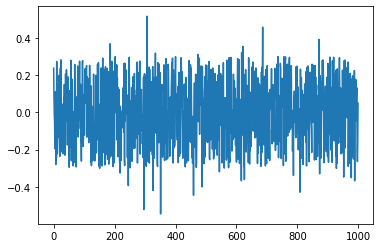

In [87]:
plt.plot(pred.cpu().detach().numpy())

In [231]:
class FBNet(nn.Module):
    def __init__(self,
                 input_shape=(1,32,32),
                 cnn_out_channels=(64, 64),
                 cnn_pct_on=(0.1, 0.1),
                 cnn_weight_sparsity=(0.5, 0.5),
                 linear_n=(1000,11),
                 linear_pct_on=(0.1,0.1),
                 linear_weight_sparsity=(0.4,0.4),
                 num_classes=11,
                 boost_strength=1.67,
                 boost_strength_factor=0.9,
                 duty_cycle_period=1000,
                 k_inference_factor=1.5,
                 use_batch_norm=True,
                 dropout=0.0,
                 activation_fct_before_max_pool=False,
                 consolidated_sparse_weights=False,
                 use_kwinners_local=False,
                ):
        
        super(FBNet, self).__init__()
        self.num_classes = num_classes
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda") if self.use_cuda else torch.device("cpu")
        
        current_input_shape = input_shape        
        cnn_layers = len(cnn_out_channels)
        input_channels = (input_shape[0], cnn_out_channels[0])
        
        for k in range(cnn_layers):
            in_channels, height, width = current_input_shape

            cnn_layer = sparse_cnn_layer(in_channels=in_channels,
                                      out_channels=cnn_out_channels[k],
                                      use_batch_norm=use_batch_norm,
                                      weight_sparsity=cnn_weight_sparsity[k],
                                      percent_on=cnn_pct_on[k],
                                     k_inference_factor=k_inference_factor,
                                     boost_strength=boost_strength,
                                     boost_strength_factor=boost_strength_factor,
                                     duty_cycle_period=duty_cycle_period,
                                     activation_fct_before_max_pool=activation_fct_before_max_pool,
                                     use_kwinners_local=use_kwinners_local,
                                     consolidated_sparse_weights=consolidated_sparse_weights,
                                        device=self.device,
                                        )
            if k == 0:
                self.cnn1, self.bn1, self.maxpool1, self.fcn1 = cnn_layer
            elif k == 1:
                self.cnn2, self.bn2, self.maxpool2, self.fcn2 = cnn_layer
                
                
            wout = (width - 5) + 1
            maxpool_width = wout // 2
            current_input_shape = (cnn_out_channels[-1], maxpool_width, maxpool_width)
        
        self.flatten = Flatten()
        
        input_size = np.prod(current_input_shape)
        linear_input_channels = [input_size, linear_n[0]]
        
        for k in range(len(linear_n)):
            linear_layer = sparse_linear_layer(input_size=linear_input_channels[k],
                                                    linear_n=linear_n[k],
                                                    use_batch_norm=use_batch_norm,
                                                    weight_sparsity=linear_weight_sparsity[k],
                                                    percent_on=linear_pct_on[k],
                                                    k_inference_factor=k_inference_factor,
                                                    boost_strength=boost_strength,
                                                    boost_strength_factor=boost_strength_factor,
                                                    duty_cycle_period=duty_cycle_period,
                                                    consolidated_sparse_weights=consolidated_sparse_weights,
                                                      device=self.device,
                                                    )
            if k == 0:
                self.linear_layer1, self.linear_bn1, self.linear_fct1 = linear_layer
            elif k == 1:
                self.linear_layer2, self.linear_bn2, self.linear_fct2 = linear_layer
       
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.linear_fb = SparseWeights(nn.Linear(self.num_classes,linear_n[0]), linear_weight_sparsity[0]).to(device)
    
    
    def forward(self, x, y):
        
        y_ = torch.eye(self.num_classes)[y].to(self.device)
        
        x = self.cnn1(x)
        x = self.bn1(x)
        x = self.maxpool1(x)
        x = self.fcn1(x)
        
        x = self.cnn2(x)
        x = self.bn2(x)
        x = self.maxpool2(x)
        x = self.fcn2(x)
        
        x = self.flatten(x)
        
        fb = self.linear_fb(y_)
        
        x = self.linear_layer1(x)
        x = self.linear_bn1(x)
#         x = self.linear_fct1(x)
        x = self.linear_fct1(x + fb)
        
        x = self.linear_layer2(x)
        x = self.linear_bn2(x)
        x = self.linear_fct2(x)
        
        out = self.softmax(x)
        return out

In [227]:
net = FBNet()
# net.cuda()
dl = experiment.full_train_loader
# x,y = next(iter(dl))

In [228]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0., weight_decay=0.)
loss_fn = F.nll_loss

In [229]:
losses = []
for x, y in dl:
    optimizer.zero_grad()
    x, y = x.cuda(), y.cuda()
    out = net(x, y)
    loss = loss_fn(out, y)
    loss.backward()
    losses.append(loss.detach().cpu().numpy())
    optimizer.step()

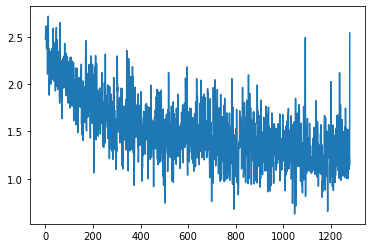

In [230]:
plt.plot(losses)

Text(0.5, 1.0, 'feedback on')

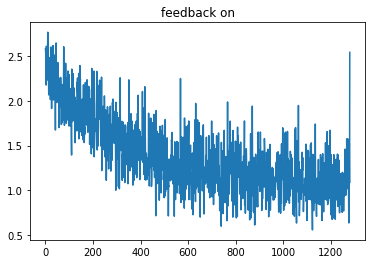

In [225]:
plt.plot(losses)
plt.title("feedback on")

In [150]:
def sparse_cnn_layer(
    in_channels,
    out_channels,
    use_batch_norm,
    weight_sparsity,
    percent_on,
    k_inference_factor,
    boost_strength,
    boost_strength_factor,
    duty_cycle_period,
    activation_fct_before_max_pool,
    use_kwinners_local,
    consolidated_sparse_weights,
    device=torch.device("cpu")
):

    cnn = nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=5,
        padding=0,
        stride=1,
    )
    if 0 < weight_sparsity < 1.0:
        if consolidated_sparse_weights:
            cnn_ = ConsolidatedSparseWeights2D(cnn, weight_sparsity)
        else:
            cnn_ = SparseWeights2d(cnn, weight_sparsity)
        
    else:
        cnn_ = cnn

    if use_batch_norm:
        bn = nn.BatchNorm2d(out_channels, affine=False)
    else:
        bn = None

    if not activation_fct_before_max_pool:
        maxpool = nn.MaxPool2d(kernel_size=2)
    else:
        maxpool = nn.MaxPool2d(kernel_size=2)

    if percent_on >= 1.0 or percent_on <= 0:
        fcn = nn.ReLU()
    else:
        kwinner_class = KWinners2dLocal if use_kwinners_local else KWinners2d
        kwinner = kwinner_class(
            channels=out_channels,
            percent_on=percent_on,
            k_inference_factor=k_inference_factor,
            boost_strength=boost_strength,
            boost_strength_factor=boost_strength_factor,
            duty_cycle_period=duty_cycle_period,
        )
        fcn = kwinner

    return cnn_.to(device), bn.to(device), maxpool.to(device), fcn.to(device)

In [151]:
def sparse_linear_layer(
    input_size,
    linear_n,
    use_batch_norm,
    weight_sparsity,
    percent_on,
    k_inference_factor,
    boost_strength,
    boost_strength_factor,
    duty_cycle_period,
    consolidated_sparse_weights,
    device=torch.device("cpu")
):

    linear = nn.Linear(input_size, linear_n)
    if 0 < weight_sparsity < 1.0:
        if consolidated_sparse_weights:
            linear_ = ConsolidatedSparseWeights(linear, weight_sparsity)
        else:
            linear_ = SparseWeights(linear, weight_sparsity)
            
    else:
        linear_ = linear

    if use_batch_norm:
        batch_norm = nn.BatchNorm1d(linear_n, affine=False)
    else:
        batch_norm = None

    if 0 < percent_on < 1.0:
        fct = KWinners(
                n=linear_n,
                percent_on=percent_on,
                k_inference_factor=k_inference_factor,
                boost_strength=boost_strength,
                boost_strength_factor=boost_strength_factor,
                duty_cycle_period=duty_cycle_period,
            )
    else:
        fct = nn.ReLU()
        
    return linear_.to(device), batch_norm.to(device), fct.to(device)


In [26]:
config_file = "../experiments.cfg"
with open(config_file) as cf:
    config_init = parse_config(cf)

exp = "sparseCNN2"
config = config_init[exp]
config["name"] = exp
config["seed"] = np.random.randint(0,200)

experiment = ContinuousSpeechExperiment(config=config)

Creating optimizer with learning rate= 0.01


In [27]:
dl = experiment.train_dataset
x,y = next(iter(dl))

In [149]:
net.cnns[0][0].to(device)

SparseWeights2d(
  weight_sparsity=0.5
  (module): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
)

In [146]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [213]:
net.linear_layer1

(SparseWeights(
   weight_sparsity=0.4
   (module): Linear(in_features=1600, out_features=1000, bias=True)
 ),
 BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True),
 KWinners(n=1000, percent_on=0.1, boost_strength=1.6699999570846558, boost_strength_factor=0.9, k_inference_factor=1.5, duty_cycle_period=1000))

In [52]:
torch.seed

606184793548221112